In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import pickle
import torch
import os
import matplotlib.pyplot as plt
import sys

/home/manity/Quick_adap/env_quick/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#sys.path.append('../')
#from util_folder.ml_utils.data_utils.conversion_utils import trig_transform

In [3]:

def trig_transform(z, max_val):
    cos_val = np.cos(2*np.pi*z/max_val)
    sin_val = np.sin(2*np.pi*z/max_val)
    return cos_val, sin_val

In [4]:
def create_ha_flow_pred(after_time_info, incident_idx, ha_model_mean, ha_model_std):
    weekdays = pd.DataFrame(after_time_info[incident_idx])[0].dt.weekday.values
    hours = pd.DataFrame(after_time_info[incident_idx])[0].dt.hour.values

    ha_model_pred_mean = []
    ha_model_pred_std = []
    for weekday, hour in zip(weekdays, hours):
        
        ha_model_pred_mean.append(ha_model_mean[weekday, hour])
        ha_model_pred_std.append(ha_model_std[weekday, hour])
    ha_model_pred_mean = torch.stack(ha_model_pred_mean).permute(1,0,2)
    ha_model_pred_std = torch.stack(ha_model_pred_std).permute(1,0,2)
    
    return ha_model_pred_mean, ha_model_pred_std

def idxs_of_longest_seq(a1):
    """Returns the indexes and length of the longest consecutive sequence of True in the list

    Args:
        a1 (list): List of booleans

    Returns:
        idxs_longest_seq (np.array): Rows contain the start and end of the sequences of True's.  
        length_seq (np.array): Contains the length of each sequence of True's
    """
    # Pad False on both ends of array, find changes using np.diff, find idxs of changes
    idx_pairs = np.where(np.diff(np.hstack(([False],a1==1,[False]))))[0].reshape(-1,2)

    if len(idx_pairs) != 0:
        # Get the island lengths, whose argmax would give us the ID of longest island.
        # Start index of that island would be the desired output
        idxs_longest_seq = idx_pairs[np.diff(idx_pairs,axis=1).argmax()]
        length_seq = np.diff(idxs_longest_seq)[0]
    else:
        idxs_longest_seq = np.array([np.inf,-np.inf])
        length_seq = 0
    return idxs_longest_seq, length_seq

def find_congestion_no_lane(residual_speed, edge_speed_stds, length_lim, std_lim):
    # Bool of affected edge at time steps [E, T]
    affect_bool_arr = (residual_speed < std_lim * -edge_speed_stds)

    # Find longest subsequences
    longest_affect_idxs, longest_affect_lengths = zip(*[idxs_of_longest_seq(row) for row in affect_bool_arr])

    # Create boolean of affected edges
    longest_affect_lengths = np.stack(longest_affect_lengths)
    longest_affect_idxs = np.stack(longest_affect_idxs)
    affected_edges = (longest_affect_lengths > length_lim)
    return affected_edges, longest_affect_lengths, longest_affect_idxs

# Load metadata and sensor locations    

In [5]:
month = 'sep'
processed_folder = 'dataset_1/processed_data/'

In [6]:
month_folder = f'dataset_1/incidents_{month}_17'
meta_path = f'dataset_1/{month}_17_dataset_metadata.pb'
with open(meta_path, 'rb') as f:
    meta_data = pickle.load(f)

In [7]:
flow_cols = meta_data['metadata']['flow_cols']
sensor_df = meta_data['metadata']['sensors_df']
sensor_df = sensor_df.reset_index()
sensor_ordering = sensor_df.ID.unique()
# sensor_ordering

idx_to_id = {k: sensor for k, sensor in enumerate(sensor_ordering)}
id_to_idx = {sensor: k for k, sensor in enumerate(sensor_ordering)}


In [8]:
sensor_gdf = gpd.GeoDataFrame(sensor_df,
                              geometry=gpd.points_from_xy(sensor_df.Longitude, 
                                                          sensor_df.Latitude))

sensor_gdf = sensor_gdf.set_crs(epsg=4326)
sensor_gdf = sensor_gdf.to_crs(epsg=3857)

# Make ADJ

In [9]:

adj = torch.zeros(215, 215)

# Freeway 5
fwy_mask = sensor_df.Fwy == 5
dir_mask = sensor_df.Dir == 'N'
sub_df = sensor_df[fwy_mask * dir_mask]
sort_df = sub_df.reset_index()
fwy_dir_idxs = [id_to_idx[id] for id in sort_df.sort_values(by=['Latitude']).ID]
for i in range(len(fwy_dir_idxs)-1):
    cur_idx = fwy_dir_idxs[i]
    next_idx = fwy_dir_idxs[i+1]
    adj[cur_idx, next_idx] = 1
    
fwy_mask = sensor_df.Fwy == 5
dir_mask = sensor_df.Dir == 'S'
sub_df = sensor_df[fwy_mask * dir_mask]
sort_df = sub_df.reset_index()
sort_df = sort_df.sort_values(by=['Latitude'], ascending=False).ID
fwy_dir_idxs = [id_to_idx[id] for id in sort_df]
for i in range(len(fwy_dir_idxs)-1):
    cur_idx = fwy_dir_idxs[i]
    next_idx = fwy_dir_idxs[i+1]
    adj[cur_idx, next_idx] = 1
    
# Freeway 91
fwy_mask = sensor_df.Fwy == 91
dir_mask = sensor_df.Dir == 'E'
sub_df = sensor_df[fwy_mask * dir_mask]
sort_df = sub_df.reset_index()
sort_df = sort_df.sort_values(by=['Longitude']).ID
fwy_dir_idxs = [id_to_idx[id] for id in sort_df]
for i in range(len(fwy_dir_idxs)-1):
    cur_idx = fwy_dir_idxs[i]
    next_idx = fwy_dir_idxs[i+1]
    adj[cur_idx, next_idx] = 1

fwy_mask = sensor_df.Fwy == 91
dir_mask = sensor_df.Dir == 'W'
sub_df = sensor_df[fwy_mask * dir_mask]
sort_df = sub_df.reset_index()
sort_df = sort_df.sort_values(by=['Longitude'], ascending=False).ID
fwy_dir_idxs = [id_to_idx[id] for id in sort_df]
for i in range(len(fwy_dir_idxs)-1):
    cur_idx = fwy_dir_idxs[i]
    next_idx = fwy_dir_idxs[i+1]
    adj[cur_idx, next_idx] = 1


# Freeway 105
fwy_mask = sensor_df.Fwy == 105
dir_mask = sensor_df.Dir == 'E'
sub_df = sensor_df[fwy_mask * dir_mask]
sort_df = sub_df.reset_index()
sort_df = sort_df.sort_values(by=['Longitude']).ID
fwy_dir_idxs = [id_to_idx[id] for id in sort_df]
for i in range(len(fwy_dir_idxs)-1):
    cur_idx = fwy_dir_idxs[i]
    next_idx = fwy_dir_idxs[i+1]
    adj[cur_idx, next_idx] = 1

fwy_mask = sensor_df.Fwy == 105
dir_mask = sensor_df.Dir == 'W'
sub_df = sensor_df[fwy_mask * dir_mask]
sort_df = sub_df.reset_index()
sort_df = sort_df.sort_values(by=['Longitude'], ascending=False).ID
fwy_dir_idxs = [id_to_idx[id] for id in sort_df]
for i in range(len(fwy_dir_idxs)-1):
    cur_idx = fwy_dir_idxs[i]
    next_idx = fwy_dir_idxs[i+1]
    adj[cur_idx, next_idx] = 1

    
# Freeway 605
fwy_mask = sensor_df.Fwy == 605
dir_mask = sensor_df.Dir == 'N'
sub_df = sensor_df[fwy_mask * dir_mask]
sort_df = sub_df.reset_index()
fwy_dir_idxs = [id_to_idx[id] for id in sort_df.sort_values(by=['Latitude']).ID]
for i in range(len(fwy_dir_idxs)-1):
    cur_idx = fwy_dir_idxs[i]
    next_idx = fwy_dir_idxs[i+1]
    adj[cur_idx, next_idx] = 1
    
fwy_mask = sensor_df.Fwy == 605
dir_mask = sensor_df.Dir == 'S'
sub_df = sensor_df[fwy_mask * dir_mask]
sort_df = sub_df.reset_index()
sort_df = sort_df.sort_values(by=['Latitude'], ascending=False).ID
fwy_dir_idxs = [id_to_idx[id] for id in sort_df]
for i in range(len(fwy_dir_idxs)-1):
    cur_idx = fwy_dir_idxs[i]
    next_idx = fwy_dir_idxs[i+1]
    adj[cur_idx, next_idx] = 1
    
# Freeway 710
fwy_mask = sensor_df.Fwy == 710
dir_mask = sensor_df.Dir == 'N'
sub_df = sensor_df[fwy_mask * dir_mask]
sort_df = sub_df.reset_index()
fwy_dir_idxs = [id_to_idx[id] for id in sort_df.sort_values(by=['Latitude']).ID]
for i in range(len(fwy_dir_idxs)-1):
    cur_idx = fwy_dir_idxs[i]
    next_idx = fwy_dir_idxs[i+1]
    adj[cur_idx, next_idx] = 1
    
fwy_mask = sensor_df.Fwy == 710
dir_mask = sensor_df.Dir == 'S'
sub_df = sensor_df[fwy_mask * dir_mask]
sort_df = sub_df.reset_index()
sort_df = sort_df.sort_values(by=['Latitude'], ascending=False).ID
fwy_dir_idxs = [id_to_idx[id] for id in sort_df]
for i in range(len(fwy_dir_idxs)-1):
    cur_idx = fwy_dir_idxs[i]
    next_idx = fwy_dir_idxs[i+1]
    adj[cur_idx, next_idx] = 1
    
    
## Intersection 1
adj[id_to_idx[716449], id_to_idx[717972]] = 1
adj[id_to_idx[716449], id_to_idx[768984]] = 1
adj[id_to_idx[717770], id_to_idx[716456]] = 1
adj[id_to_idx[717770], id_to_idx[716450]] = 1
adj[id_to_idx[716457], id_to_idx[717972]] = 1
adj[id_to_idx[716457], id_to_idx[768984]] = 1
adj[id_to_idx[716857], id_to_idx[760599]] = 1
adj[id_to_idx[716857], id_to_idx[716456]] = 1


## Intersection 2
adj[id_to_idx[773381], id_to_idx[774372]] = 1
adj[id_to_idx[773381], id_to_idx[717968]] = 1
adj[id_to_idx[774373], id_to_idx[717396]] = 1
adj[id_to_idx[774373], id_to_idx[773382]] = 1
adj[id_to_idx[717397], id_to_idx[774372]] = 1
adj[id_to_idx[717397], id_to_idx[717968]] = 1
adj[id_to_idx[717970], id_to_idx[773382]] = 1
adj[id_to_idx[717970], id_to_idx[717396]] = 1

## Intersection 3
adj[id_to_idx[716312], id_to_idx[716775]] = 1
adj[id_to_idx[716312], id_to_idx[773749]] = 1
adj[id_to_idx[717854], id_to_idx[766209]] = 1
adj[id_to_idx[717854], id_to_idx[716314]] = 1
adj[id_to_idx[717428], id_to_idx[717857]] = 1
adj[id_to_idx[717428], id_to_idx[716776]] = 1
adj[id_to_idx[716778], id_to_idx[716311]] = 1
adj[id_to_idx[716778], id_to_idx[766209]] = 1

# Intersection 4
adj[id_to_idx[716470], id_to_idx[718466]] = 1
adj[id_to_idx[716470], id_to_idx[717871]] = 1
adj[id_to_idx[716784], id_to_idx[716471]] = 1
adj[id_to_idx[717872], id_to_idx[716471]] = 1

# Intersection 5
adj[id_to_idx[717875], id_to_idx[715920]] = 1
adj[id_to_idx[717875], id_to_idx[763985]] = 1
adj[id_to_idx[715918], id_to_idx[717879]] = 1
adj[id_to_idx[715918], id_to_idx[717877]] = 1
adj[id_to_idx[717884], id_to_idx[763985]] = 1
adj[id_to_idx[717884], id_to_idx[715920]] = 1
adj[id_to_idx[763990], id_to_idx[717877]] = 1
adj[id_to_idx[763990], id_to_idx[717879]] = 1

In [10]:
#####Save the ADJ###
torch.save(adj, f'{processed_folder}/PEMS_d7_adj_{month}.pt')
####################

# Connect incidents to sensors

In [11]:
incident_files = os.listdir(month_folder)
#inci_path = 'real_world_data/dataset_1/incidents'

In [12]:
# Load all of the incident files
info_arr = []
for incident_file in incident_files:
    path = f'{month_folder}/{incident_file}'
    with open(path, 'rb') as f:
        inci_data = pickle.load(f)
        info_arr.append(inci_data['acc_info'])
        street, street_dir = inci_data['acc_info'].Street.split('-')[1].split(' ')
        
incident_df = pd.DataFrame(info_arr)

# Split street name into what have from the meta data
temp_df = incident_df.Street.str.split('-', expand=True)[1].str.split(' ', expand=True)
incident_df['Street_Number'] = temp_df[0]
incident_df['Street_Dir'] = temp_df[1]

# Clean df and make a geopandas dataframe for plotting if necessary
incident_df = incident_df.reset_index()
incident_df.Street_Dir = incident_df.Street_Dir.astype('category')
incident_gdf = gpd.GeoDataFrame(incident_df,
                              geometry=gpd.points_from_xy(incident_df.LocationLng, 
                                                          incident_df.LocationLat))
incident_gdf = incident_gdf.set_crs(epsg=4326)
incident_gdf = incident_gdf.to_crs(epsg=3857)

Next cell is where the magic happens

In [13]:
# Find the closest upstream sensor using the compas direction of the street of the incident.
closest_sensor_arr = []

for i, incident_row in incident_df.iterrows():
    # Find the sensors on the fwy in the correct direction
    street_mask = sensor_df.Fwy == int(incident_row.Street_Number)
    dir_mask = sensor_df.Dir == incident_row.Street_Dir
    sub_df = sensor_df[street_mask * dir_mask]
    sort_df = sub_df.reset_index()
    
    # Sort and insert the incident based on the compas direction of the fwy
    if incident_row.Street_Dir == 'N':
        sort_df = sort_df.sort_values(by=['Latitude'])
        sort_idx = sort_df.Latitude.searchsorted(incident_row.LocationLat) - 1
        closest_sensor_id = sort_df.iloc[sort_idx].ID
        closest_sensor_idx = id_to_idx[closest_sensor_id]
        closest_sensor_arr.append(closest_sensor_idx)
        
    elif incident_row.Street_Dir == 'S':
        sort_df = sort_df.sort_values(by=['Latitude'])
        sort_idx = sort_df.Latitude.searchsorted(incident_row.LocationLat)
        closest_sensor_id = sort_df.iloc[sort_idx].ID
        closest_sensor_idx = id_to_idx[closest_sensor_id]
        closest_sensor_arr.append(closest_sensor_idx)
        
    elif incident_row.Street_Dir == 'E':
        sort_df = sort_df.sort_values(by=['Longitude'])
        sort_idx = sort_df.Longitude.searchsorted(incident_row.LocationLng) - 1
        closest_sensor_id = sort_df.iloc[sort_idx].ID
        closest_sensor_idx = id_to_idx[closest_sensor_id]
        closest_sensor_arr.append(closest_sensor_idx)

    elif incident_row.Street_Dir == 'W':
        sort_df = sort_df.sort_values(by=['Longitude'])
        sort_idx = sort_df.Longitude.searchsorted(incident_row.LocationLng)
        closest_sensor_id = sort_df.iloc[sort_idx].ID
        closest_sensor_idx = id_to_idx[closest_sensor_id]
        closest_sensor_arr.append(closest_sensor_idx)
    else:
        print(incident_row.Street_Dir)

In [14]:
#incident_files[i]

In [15]:
# Add the closes sensor and duration of the incident to the df
incident_df['closest_sensor_idx'] = closest_sensor_arr
incident_df['closest_sensor_id'] = incident_df['closest_sensor_idx'].map(idx_to_id)

incident_df['StartTime(UTC)'] = pd.to_datetime(incident_df['StartTime(UTC)'], format='%Y-%m-%d %H:%M:%S')
incident_df['EndTime(UTC)'] = pd.to_datetime(incident_df['EndTime(UTC)'], format='%Y-%m-%d %H:%M:%S')

incident_df['Duration'] = (incident_df['EndTime(UTC)'] - incident_df['StartTime(UTC)']) / np.timedelta64(1, 's')

In [16]:
# Create a tensor of the data
incident_info = torch.tensor(incident_df[['closest_sensor_idx', 'Severity', 'TMC', 'Duration']].values)

In [17]:
##########Save Incident Info ########
torch.save(incident_info, f'{processed_folder}/incident_info_{month}.pt')
#####################################

# Load incident flow data

In [18]:
# Load all of the before incident flow
before_arr = []
for incident_file in incident_files:
    path = f'{month_folder}/{incident_file}'
    with open(path, 'rb') as f:
        inci_data = pickle.load(f)
    before_arr.append(inci_data['flow_before_acc'])

In [19]:
# Go from pandas dataframe in long format to a [E, T, F] torch tensor using pandas multi index
input_flow_arr = []
trig_time_arr = []
for file_idx, before_dict in enumerate(before_arr):

    flow_df = None

    # Load all of the sensors data and create df
    for i, (sensor, sensor_dict) in enumerate(before_dict.items()):
        assert (sensor_ordering[i] == sensor) # Check that we have the correct order for all obs
        curr_df = pd.DataFrame(sensor_dict, columns=flow_cols)[['Timestamp', 'Station', 'Avg Occupancy', 'Avg Speed', 'Total Flow']]
        if flow_df is None:
            flow_df = curr_df
        else:
            flow_df = pd.concat([flow_df, curr_df])
    flow_df.Timestamp = pd.to_datetime(flow_df.Timestamp, format='%m/%d/%Y %H:%M:%S')

    # Find the sensors and timestamps to create multiindex
    sensors = flow_df.Station.unique()
    time = flow_df.Timestamp.unique()
    index_names = ['Station', 'Timestamp']
    multi_index = pd.MultiIndex.from_product([sensors, time], names = index_names)

    # Quick fix of trouble with the dates. Sometimes the datetimes from the different sensors
    # do not match. In this case din't use the data
    if len(time) == 12:
        # Set the multiindex so we now the following reshape does the correct reshaping
        # I.e. the data is in sensor, time, feature ordering
        flow_df = flow_df.set_index(index_names)
        flow_matrix = flow_df.values.reshape(len(sensors), len(time), 3)

        input_flow_arr.append(torch.tensor(flow_matrix.astype(float)))
        
        # Save time features
        datetimes = pd.Series(time).dt
        weekday = datetimes.weekday
        minutes_of_day = (datetimes.hour*60+datetimes.minute)

        # Do trig transform of time feature
        minutes_in_day = 24 * 60 
        days_in_week = 7
        trig_minutes = np.array([trig_transform(minutes, minutes_in_day) for minutes in minutes_of_day])   
        trig_dows = np.array([trig_transform(dow, days_in_week) for dow in weekday])   
        trig_time_temp = np.concatenate([trig_dows, trig_minutes], axis=-1)

        trig_time_arr.append(trig_time_temp)
    else:
        print(f'File {incident_files[file_idx]} is corrupt')

# Create the overall tensor
input_data = torch.stack(input_flow_arr)
trig_time = torch.tensor(np.array(trig_time_arr)) 

In [20]:
##########Save input Info ########
torch.save(input_data, f'{processed_folder}/input_data_{month}.pt')
torch.save(trig_time, f'{processed_folder}/input_time_data_{month}.pt')
#####################################

# Create the after incident flow
works the same way as the above

In [21]:
after_arr = []
for incident_file in incident_files:
    path = f'{month_folder}/{incident_file}'
    with open(path, 'rb') as f:
        inci_data = pickle.load(f)
    after_arr.append(inci_data['flow_after_acc'])

In [22]:
after_flow_arr = []
after_time_arr = []
for file_idx, after_dict in enumerate(after_arr):

    flow_df = None

    for i, (sensor, sensor_dict) in enumerate(after_dict.items()):
        assert (sensor_ordering[i] == sensor) # Check that we have the correct order for all obs
        curr_df = pd.DataFrame(sensor_dict, columns=flow_cols)[['Timestamp', 'Station', 'Avg Occupancy', 'Avg Speed', 'Total Flow']]
        if flow_df is None:
            flow_df = curr_df
        else:
            flow_df = pd.concat([flow_df, curr_df])


    
    flow_df.Timestamp = pd.to_datetime(flow_df.Timestamp, format='%m/%d/%Y %H:%M:%S')

    sensors = flow_df.Station.unique()
    time = flow_df.Timestamp.unique()
    index_names = ['Station', 'Timestamp']
    multi_index = pd.MultiIndex.from_product([sensors, time], names = index_names)
    if len(time) == 60:
        flow_df = flow_df.set_index(index_names)
        flow_matrix = flow_df.values.reshape(len(sensors), len(time), 3)

        after_time_arr.append(time)
        after_flow_arr.append(torch.tensor(flow_matrix.astype(float)))
    else:
        print(f'File {incident_files[file_idx]} is corrupt')

after_data = torch.stack(after_flow_arr)

In [23]:
######### Save after time info #######
after_time_info = np.stack(after_time_arr)
np.save(f'{processed_folder}/after_time_info_{month}.npy', after_time_info)
####################################

In [24]:
##########Save after data ########
torch.save(after_data, f'{processed_folder}/after_data_{month}.pt')
#####################################

# Create network info

In [25]:
num_nodes = adj.shape[0]

In [26]:
incident_info.shape

torch.Size([104, 4])

In [27]:
stream_levels = 30
network_info_arr = []
upstream_dicts = []

for incident in incident_info:
    ie_idx = [int(incident[0])]
    upstream_dict = {} 
    upstream_dict[0] = ie_idx

    # Loop over upstream levels
    for i in range(stream_levels):
        next_edges = []
    
        # Loop edges in current level
        for j in upstream_dict[i]:

            # Find next level edges and save them
            test = (adj[:, j].argwhere().squeeze(1).tolist())
            next_edges += test 
        upstream_dict[i+1] = next_edges

    upstream_dicts.append(upstream_dict)

    downstream_dict = {} 
    downstream_dict[0] = ie_idx
    for i in range(30):
        next_edges = []
    
        for j in downstream_dict[i]:
            test = (adj[j].argwhere().squeeze(1).tolist())
            next_edges += test 
        downstream_dict[i+1] = next_edges

    network_info = torch.ones(num_nodes) * 200

    for level in upstream_dict.keys():
        edge_idxs = upstream_dict[level]
        for edge_idx in edge_idxs:
            if network_info[edge_idx] == 200:
                network_info[edge_idx] = -level

    for level in downstream_dict.keys():
        edge_idx = downstream_dict[level]
        for edge_idx in edge_idxs:
            if network_info[edge_idx] == 200:
                network_info[edge_idx] = level
    
    network_info_arr.append(network_info)

In [28]:
network_info_tensor = torch.stack(network_info_arr)

In [29]:
##########Save after Info ########
torch.save(network_info_tensor, f'{processed_folder}/network_info_{month}.pt')
#####################################

# Infer target

In [30]:
## Load HA model
ha_model_mean = torch.tensor(np.load('dataset_1/ha_model_mean.npy')).permute(1,2,0,3)
ha_model_std = torch.tensor(np.load('dataset_1/ha_model_std.npy')).permute(1,2,0,3)

In [31]:
target_data_arr = []
for idx in range(after_time_info.shape[0]):
    # Create historical average predictions of traffic flow
    ha_model_pred_mean, ha_model_pred_std = create_ha_flow_pred(after_time_info=after_time_info, 
                                                                incident_idx=idx,
                                                                ha_model_mean=ha_model_mean,
                                                                ha_model_std=ha_model_std)

    # Create residual from HA model
    residual_data = after_data[idx, :,:, 1] - ha_model_pred_mean[...,2] 
    

    # Find the edges that are affected by congestions based on HA model and hyperparamters
    # length_lim : how many consecutive timesteps the flow has to be outside the threshold area
    # std_lim : how many standard deviations away fom the HA model we set the threshold
    length_lim = 2
    std_lim = 1
    (affected_edges, _, _) = find_congestion_no_lane(residual_speed=residual_data,
                                                    edge_speed_stds=ha_model_pred_std[...,2],
                                                    length_lim=length_lim,
                                                    std_lim=std_lim)

    # Only look at upstream edges
    upstream_mask = network_info_tensor[idx].numpy() <= 0
    affected_us_mask = affected_edges * upstream_mask
    affected_upstream_edge_idxs = np.where(affected_us_mask)[0]

    # Find the start and end times for the edges that are congested using looser rules
    (_, longest_affect_lengths, longest_affect_idxs) = find_congestion_no_lane(residual_speed=residual_data,
                                                                                    edge_speed_stds=ha_model_pred_std[...,2],
                                                                                    length_lim=1,
                                                                                    std_lim=0.5)

    # Save the found congestion times
    cong_start_time = longest_affect_idxs[...,0]
    cong_end_time = longest_affect_idxs[...,1]
    cong_start_time[(longest_affect_lengths < length_lim)] = np.inf
    cong_end_time[(longest_affect_lengths < length_lim)] = -np.inf
    cong_start_time[~affected_us_mask] = 0
    cong_end_time[~affected_us_mask] = 0


    n_edges = len(residual_data)  
    # Calculate the max speed decrease
    delta_speeds = np.zeros((n_edges))
    for edge in affected_upstream_edge_idxs:
        start_time = int(cong_start_time[edge])
        end_time = int(cong_end_time[edge])
        delta_speeds[edge] = residual_data[edge, start_time:end_time].min()

    target_data_temp = np.stack([affected_us_mask, cong_start_time, cong_end_time, delta_speeds], axis=-1)
    target_data_arr.append(target_data_temp)

In [32]:
target_data = np.array(target_data_arr)
target_data = torch.tensor(target_data)

In [33]:
##########Save target data ########
torch.save(target_data, f'{processed_folder}/target_data_{month}.pt')
#####################################

In [34]:
process_len = target_data.shape[0]
assert input_data.shape[0] == process_len
assert network_info_tensor.shape[0] == process_len
assert incident_info.shape[0] == process_len
assert target_data.shape[0] == process_len
assert after_data.shape[0] == process_len

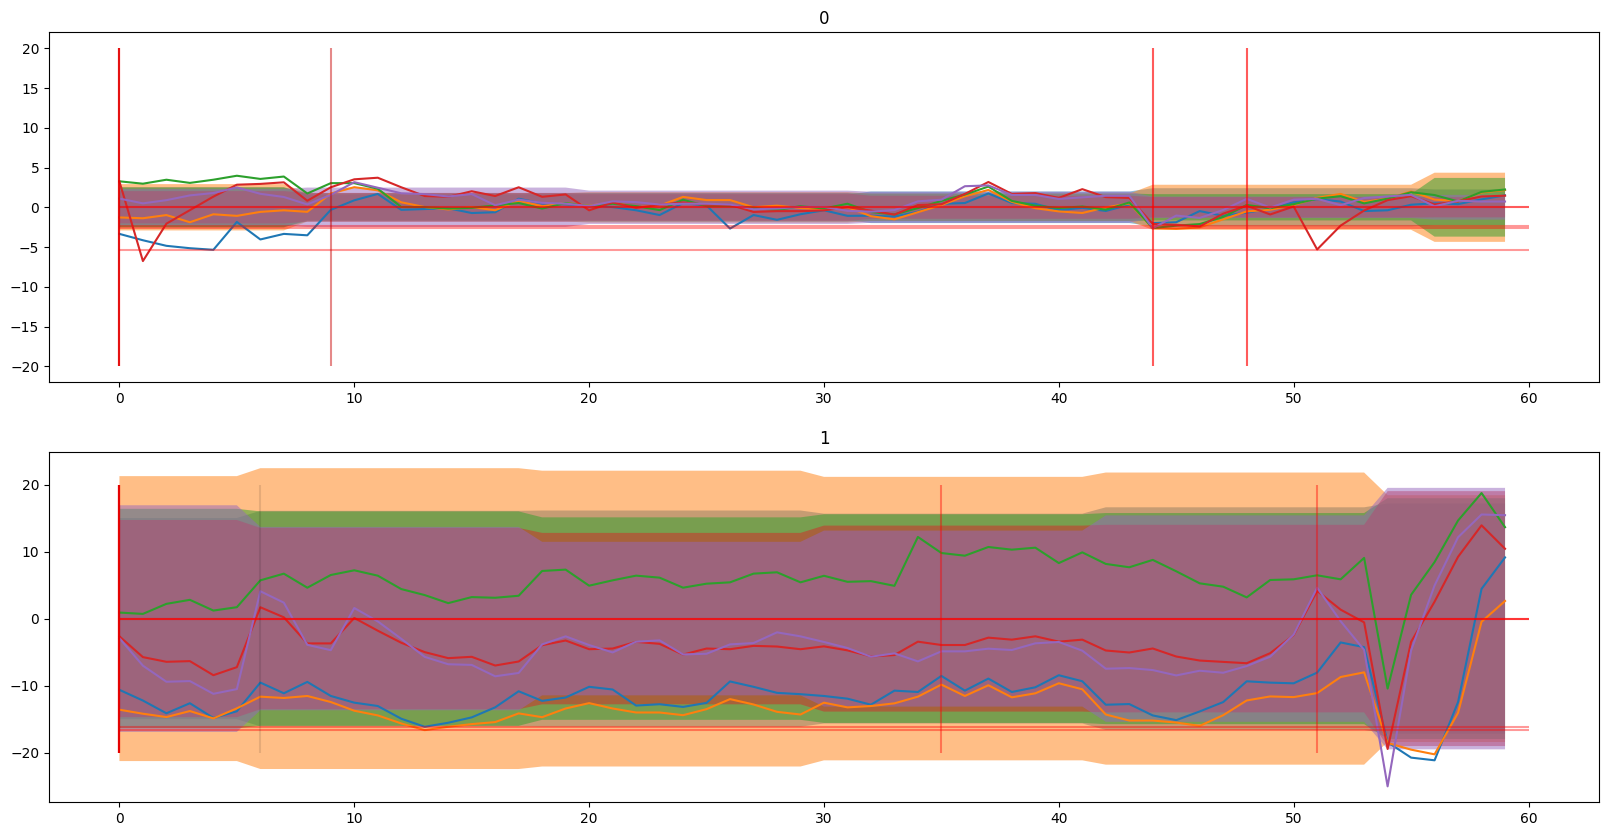

In [35]:


num_plots = 2
fig, axs = plt.subplots(num_plots, figsize=(20,5 * num_plots))

for i, idx in enumerate([30, 60]):
    
    
    ha_model_pred_mean, ha_model_pred_std = create_ha_flow_pred(after_time_info=after_time_info, 
                                                                incident_idx=idx,
                                                                ha_model_mean=ha_model_mean,
                                                                ha_model_std=ha_model_std)


    duration = torch.round(incident_info[idx, -1].long() / (60 * 5))

    upstream_mask = (network_info_tensor[idx] <= 0) & (network_info_tensor[idx] > -5)
    #   upstream_mask = (network_info_tensor[i] > 0) & (network_info_tensor[i] < 3)

    data = torch.cat([input_data[idx, upstream_mask,:, 1], after_data[idx, upstream_mask,:, 1]], dim = 1).T
    ha_pred_data = ha_model_pred_mean[upstream_mask, :, 2].T
    ha_pred_data_std = ha_model_pred_std[upstream_mask, :, 2].T

    axs[i].plot(range(0,60), data[12:] - ha_pred_data)

    for j in range(ha_pred_data.shape[-1]):
        axs[i].fill_between(x = range(0, 60), 
                            y1= (-ha_pred_data_std[:, j]).squeeze(),
                            y2= (ha_pred_data_std[:, j]).squeeze(),
                            alpha = 0.5)

        cong_start = target_data[idx][upstream_mask][j][1]
        cong_end = target_data[idx][upstream_mask][j][2]
        cong_vspeed = target_data[idx][upstream_mask][j][3]

        axs[i].vlines(cong_start, ymin=-20, ymax=20, colors='red', alpha=0.4)
        axs[i].vlines(cong_end, ymin=-20, ymax=20, colors='red', alpha=0.4)
        axs[i].hlines(cong_vspeed,xmin=0, xmax=60, colors='red', alpha=0.4)

    axs[i].vlines(0, ymin=-20, ymax=20, colors='black', alpha=0.1)
    axs[i].vlines(duration, ymin=20, ymax=-20, colors='black', alpha=0.1)
    axs[i].set_title(f'{i}')